### References
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- https://github.com/soumith/ganhacks

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2 as T
import torchvision.utils as vutils
import random
from torch.utils.data.dataset import random_split
from torchmetrics.image.fid import FrechetInceptionDistance

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64
NZ = 256        # Размер векторра шума z
NGF = 32        # Размер модификатора каналов в генераторе
NDF = 32        # Размер модификатора каналов в дискриминаторе
NC = 3          # Количество каналов в изображении
BETA_1 = 0.5    # B1 коэффициент оптимизатора
CLASS_N = 11    # Количество классов в датасете

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input: NZ
            nn.ConvTranspose2d(NZ, NGF * 12, 4, 1, 0, bias=False),
            nn.BatchNorm2d(NGF * 12),
            nn.ReLU(True),
            # ngf*12 x 4 x 4 
            nn.ConvTranspose2d(NGF * 12, NGF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 8),
            nn.ReLU(True),
            # ngf*8 x 8 x 8 
            nn.ConvTranspose2d(NGF * 8, NGF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 4),
            nn.ReLU(True),
            # ngf*4 x 16 x 16
            nn.ConvTranspose2d(NGF * 4, NGF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 2),
            nn.ReLU(True),
            # ngf*2 x 32 x 32
            nn.ConvTranspose2d(NGF * 2, NGF , 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF),
            nn.ReLU(True),
            # ngf x 64 x 64
            nn.ConvTranspose2d(NGF, NC, 4, 2, 1, bias=False),
            nn.Tanh(),
            # nc x 128 x 128
        )

    def forward(self, x, rnd=0.005):
        x = self.main(x)
        noise = (rnd**0.5)*torch.randn(x.shape, device=DEVICE).detach()
        return x + noise

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input: nc x 128 x 128
            nn.Conv2d(NC, NDF, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf x 64 x 64
            nn.Conv2d(NDF, NDF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*2 x 32 x 32
            nn.Conv2d(NDF * 2, NDF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*4 x 16 x 16
            nn.Conv2d(NDF * 4, NDF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*8 x 8 x 8
            nn.Conv2d(NDF * 8, NDF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*8 x 4 x 4
        )

        self.image_classification = nn.Sequential(
            nn.Conv2d(NDF * 8, CLASS_N, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.fake_classification = nn.Sequential(
            nn.Conv2d(NDF * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        fake = self.fake_classification(x)
        label = self.image_classification(x)
        return fake, label

In [5]:
def train(models, data_loader: DataLoader, optimizers: tuple, loss_fn, class_loss_fn, rnd=0.005):
    D, G = models
    G.train()
    D.train()

    d_optim, g_optim = optimizers
    train_d_loss, train_g_loss = 0, 0

    for real_img, class_label in data_loader:
        real_img, class_label = real_img.to(DEVICE), class_label.to(DEVICE)
        batch_size = real_img.size(0)

        fake_img = G(torch.randn(batch_size, NZ, 1, 1, device=DEVICE), rnd)

        # добавляем шум в входные данные
        real_img = real_img + (rnd**0.5)*torch.randn(real_img.shape, device=DEVICE).detach()
       
        # тренируем дискриминатор
        d_optim.zero_grad()
        # реальные изображения
        true_outs, label = D(real_img)
        d_real_loss = loss_fn(true_outs, torch.ones_like(true_outs, device=DEVICE).uniform_(0.9, 0.9))
        d_real_loss = d_real_loss + class_loss_fn(label.squeeze(2, 3), class_label)
        d_real_loss.backward()

        # фейковые изображения
        fake_outs, _ = D(fake_img.detach())
        d_fake_img_loss = loss_fn(fake_outs, torch.zeros_like(fake_outs, device=DEVICE))
        d_fake_img_loss.backward()  
        d_optim.step()
        
        # тренируем генератор
        g_optim.zero_grad()
        fake_outs_, _ = D(fake_img)
        g_loss = loss_fn(fake_outs_, torch.ones_like(fake_outs_, device=DEVICE).uniform_(0.9, 0.9))
        g_loss.backward()
        g_optim.step()

        train_d_loss += (d_real_loss + d_fake_img_loss).item()
        train_g_loss += g_loss.item()

    train_g_loss /= len(data_loader)
    train_d_loss /= len(data_loader)

    return train_d_loss, train_g_loss

In [6]:
def rescale(tensor):
    tensor -= tensor.min() 
    tensor /= tensor.max() 
    return tensor

def eval(model, data_loader, fid):
    G = model
    G.to(DEVICE)
    G.eval()

    for real_img, _ in data_loader:
        real_img = real_img.to(DEVICE)
        batch_size = real_img.size(0)
        fake_img = G(torch.randn(batch_size, NZ, 1, 1, device=DEVICE))

        fid.update(real_img.to(torch.uint8), real=True)
        fid.update(fake_img.to(torch.uint8), real=False)

    score = fid.compute()
    fid.reset()
    return score

In [10]:
image_dataset = ImageFolder(
    root='planets\\',
    transform=T.Compose([
        T.Resize(128),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))

train_data , eval_data = random_split(image_dataset, (int(len(image_dataset) * 0.9), len(image_dataset) - int(len(image_dataset) * 0.9)))
data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
eval_data_loader = torch.utils.data.DataLoader(eval_data, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
G = Generator()
D = Discriminator()

G.apply(weights_init)
D.apply(weights_init)

G.to(DEVICE)
D.to(DEVICE)

g_optim = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(BETA_1, 0.999))
d_optim = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(BETA_1, 0.999))
loss_fn = nn.BCELoss()
class_loss_fn = nn.CrossEntropyLoss()
fid = FrechetInceptionDistance(feature=2048, reset_real_features=False).to(DEVICE)

In [12]:
fix_noise = torch.randn(16, NZ, 1, 1, device=DEVICE)


def plot_examples(title=None):
    G.eval()
    D.eval()

    plt.figure(figsize=(10, 4))
    images = G(fix_noise)

    plt.imshow(np.transpose(vutils.make_grid(images.cpu(), padding=5, normalize=True), (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

In [13]:
def change_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

epoch:1, d loss:2.6655951738357544, g loss:3.0915550887584686
epoch:2, d loss:2.352802848815918, g loss:4.428289616107941
epoch:3, d loss:2.2216914534568786, g loss:4.863122618198394
epoch:4, d loss:2.1512921810150147, g loss:4.457523131370545
epoch:5, d loss:2.1390797019004824, g loss:4.206200516223907
epoch:6, d loss:2.3996500849723814, g loss:4.916253173351288
epoch:7, d loss:2.1307192206382752, g loss:4.1297613143920895
epoch:8, d loss:2.117685914039612, g loss:4.4776108980178835
epoch:9, d loss:2.173564648628235, g loss:4.009138417243958
epoch:10, d loss:2.169992607831955, g loss:3.6322050631046294
epoch:11, d loss:2.1850454688072203, g loss:3.58526269197464
epoch:12, d loss:2.2227550745010376, g loss:3.6532681405544283
epoch:13, d loss:2.47046035528183, g loss:3.2039653450250625
epoch:14, d loss:2.194881761074066, g loss:3.21205558180809
epoch:15, d loss:2.1413072288036346, g loss:3.2078128337860106
epoch:16, d loss:2.4636765003204344, g loss:3.238046732544899
epoch:17, d loss:2.

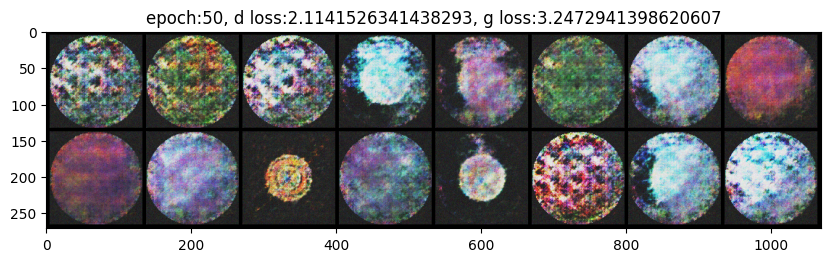

epoch:51, d loss:2.170913499593735, g loss:3.349409008026123
epoch:52, d loss:2.072567754983902, g loss:3.2388574540615083
epoch:53, d loss:2.0651121616363524, g loss:3.2059623122215273
epoch:54, d loss:2.0123473584651945, g loss:3.2818502306938173
epoch:55, d loss:2.1936674892902372, g loss:3.4922571778297424
epoch:56, d loss:2.1723036646842955, g loss:3.259101939201355
epoch:57, d loss:2.0061805725097654, g loss:3.2043325901031494
epoch:58, d loss:2.0259001910686494, g loss:3.21592857837677
epoch:59, d loss:2.0967615723609923, g loss:3.2111233115196227
epoch:60, d loss:2.231330907344818, g loss:3.3948874950408934
epoch:61, d loss:2.063701665401459, g loss:3.181467866897583
epoch:62, d loss:2.016087073087692, g loss:3.1483955502510073
epoch:63, d loss:2.0661774456501005, g loss:3.231576347351074
epoch:64, d loss:2.100443834066391, g loss:3.5549245476722717
epoch:65, d loss:1.9706641674041747, g loss:3.3657615780830383
epoch:66, d loss:2.0018728911876678, g loss:3.3736010789871216
epoc

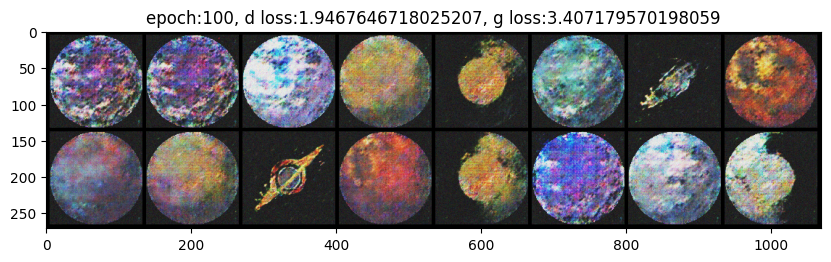

epoch:101, d loss:1.9566632449626922, g loss:3.1894543170928955
epoch:102, d loss:1.9435603678226472, g loss:3.4370372176170347
epoch:103, d loss:1.9477147519588471, g loss:3.3829298973083497
epoch:104, d loss:1.9487378180027009, g loss:3.5206096172332764
epoch:105, d loss:1.985383540391922, g loss:3.2603816747665406
epoch:106, d loss:1.955088233947754, g loss:3.4284453868865965
epoch:107, d loss:1.9535565018653869, g loss:3.3587613105773926
epoch:108, d loss:2.02623627781868, g loss:3.310226720571518
epoch:109, d loss:1.980353021621704, g loss:3.3690973043441774
epoch:110, d loss:1.949786329269409, g loss:3.4023099184036254
epoch:111, d loss:1.9358502328395844, g loss:3.5282819509506225
epoch:112, d loss:1.9905537068843842, g loss:3.3248769283294677
epoch:113, d loss:1.9539508521556854, g loss:3.4470223903656008
epoch:114, d loss:1.9480418384075164, g loss:3.377132475376129
epoch:115, d loss:1.9440701305866241, g loss:3.4963412523269652
epoch:116, d loss:1.9460455119609832, g loss:3.4

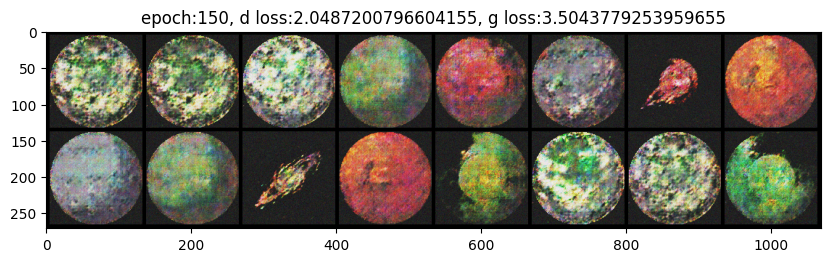

epoch:151, d loss:1.9350619435310363, g loss:3.7371779084205627
epoch:152, d loss:1.9261064231395721, g loss:3.664174795150757
epoch:153, d loss:1.9325487971305848, g loss:3.762773597240448
epoch:154, d loss:1.9339545011520385, g loss:3.706117534637451
epoch:155, d loss:1.930328184366226, g loss:3.7675156950950623
epoch:156, d loss:1.9441367864608765, g loss:3.7965666174888613
epoch:157, d loss:1.9741973340511323, g loss:3.7617947459220886
epoch:158, d loss:1.9317302048206328, g loss:3.915203309059143
epoch:159, d loss:1.9592344343662262, g loss:3.8593617558479307
epoch:160, d loss:1.914055550098419, g loss:3.8943018555641173
epoch:161, d loss:1.9107136249542236, g loss:3.900986301898956
epoch:162, d loss:1.9699156761169434, g loss:3.5802356481552122
epoch:163, d loss:1.949788933992386, g loss:4.048768305778504
epoch:164, d loss:1.9156370759010315, g loss:3.992030394077301
epoch:165, d loss:1.9262695848941802, g loss:4.0423782706260685
epoch:166, d loss:1.9582945942878722, g loss:3.966

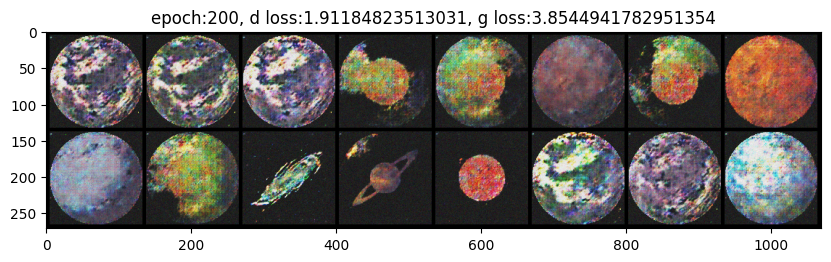

epoch:201, d loss:1.9097315788269043, g loss:3.648363399505615
epoch:202, d loss:1.9219493389129638, g loss:3.6534677386283874
epoch:203, d loss:1.9100500106811524, g loss:3.804519701004028
epoch:204, d loss:1.9022810757160187, g loss:3.962490367889404
epoch:205, d loss:1.9006659090518951, g loss:3.989400398731232
epoch:206, d loss:1.916444981098175, g loss:3.7506816387176514
epoch:207, d loss:1.902897733449936, g loss:3.9291985273361205
epoch:208, d loss:1.9019122123718262, g loss:3.8168330550193788
epoch:209, d loss:1.9049589514732361, g loss:3.7640814542770387
epoch:210, d loss:1.9058913230895995, g loss:3.845230531692505
epoch:211, d loss:1.9092557072639464, g loss:3.7928181648254395
epoch:212, d loss:1.903292828798294, g loss:3.995447206497192
epoch:213, d loss:1.9014218032360077, g loss:3.898417830467224
epoch:214, d loss:1.9054690539836883, g loss:3.9749096393585206
epoch:215, d loss:1.8948431670665742, g loss:4.204834139347076
epoch:216, d loss:1.9016735255718231, g loss:3.9006

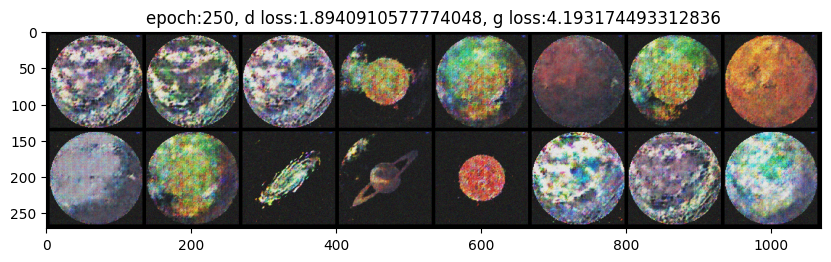

epoch:251, d loss:1.8971179246902465, g loss:4.085612201690674
epoch:252, d loss:1.9031799256801605, g loss:4.112921237945557
epoch:253, d loss:1.8976728916168213, g loss:4.255855524539948
epoch:254, d loss:1.9001100599765777, g loss:4.171807658672333
epoch:255, d loss:1.8997157514095306, g loss:4.111226320266724
epoch:256, d loss:1.8994995474815368, g loss:4.330130040645599
epoch:257, d loss:1.898384165763855, g loss:4.147844111919403
epoch:258, d loss:1.9015501976013183, g loss:4.010964810848236
epoch:259, d loss:1.8979167878627776, g loss:4.0034900307655334
epoch:260, d loss:1.8969175398349762, g loss:4.088471555709839
epoch:261, d loss:1.903376317024231, g loss:4.090115797519684
epoch:262, d loss:1.8956901550292968, g loss:4.184299671649933
epoch:263, d loss:1.8986079037189483, g loss:4.257166421413421
epoch:264, d loss:1.9052674531936646, g loss:4.0700224995613095
epoch:265, d loss:1.8990774512290955, g loss:4.097769498825073
epoch:266, d loss:1.9015635669231414, g loss:4.05828621

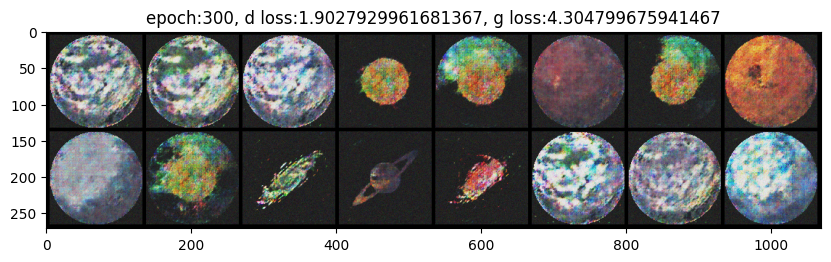

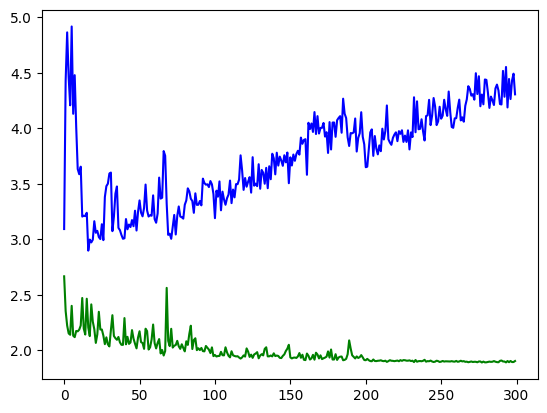

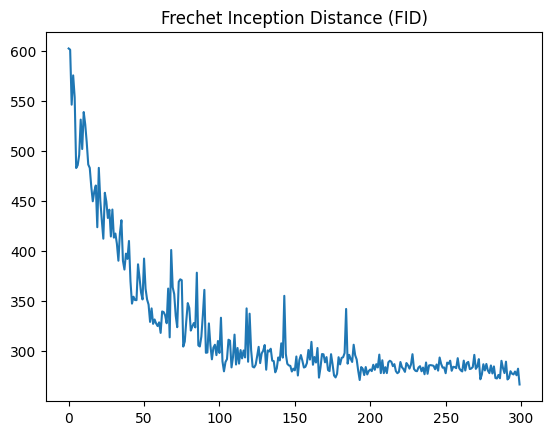

In [14]:
all_d_loss, all_g_loss, all_fid_score = [], [], []
rnd = random.uniform(0, 0.2)
for e in range(1, 301):
    if e == 100:
        change_lr(g_optim, 1e-4)
        change_lr(d_optim, 1e-4)
        rnd = random.uniform(0, 0.1)
    if e == 200:
        change_lr(g_optim, 2e-5)
        change_lr(d_optim, 2e-5)
        rnd = random.uniform(0, 0.05)

    d_loss, g_loss = train((D, G), data_loader, (d_optim, g_optim), loss_fn, class_loss_fn, rnd)
    all_d_loss.append(d_loss)
    all_g_loss.append(g_loss)

    fid_score = eval(G, eval_data_loader, fid)
    all_fid_score.append(fid_score.cpu())
    print(f'epoch:{e}, d loss:{d_loss}, g loss:{g_loss}')
    if e % 50 == 0:
        plot_examples(f'epoch:{e}, d loss:{d_loss}, g loss:{g_loss}')

plt.plot(all_d_loss, color='green')
plt.plot(all_g_loss, color='blue')
plt.show()

plt.plot(all_fid_score)
plt.title('Frechet Inception Distance (FID)')
plt.show()

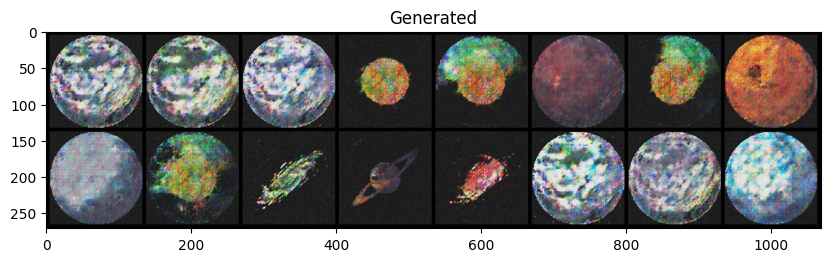

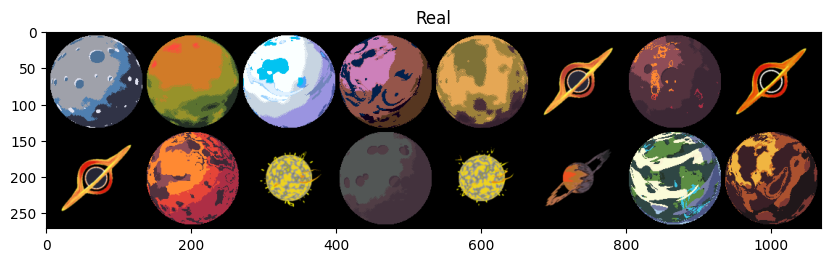

In [15]:
plot_examples('Generated')
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(vutils.make_grid(next(iter(data_loader))[0][:16], padding=5, normalize=True), (1, 2, 0)))
plt.title('Real')
plt.show()